In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax for a year in the data set
start_date = '2016-03-18'
end_date = '2016-03-21'
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs))\
        .filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
yearly_temps=calc_temps(start_date, end_date)
yearly_temps

[(66.0, 70.36363636363636, 75.0)]

In [11]:
# Create Dataframe
yearly_temps_df = pd.DataFrame({'start date': start_date,
                               'end_date': end_date,
                               'min_temp': [yearly_temps[0][0]],
                               'avg_temp': [yearly_temps[0][1]],
                               'max_temp': [yearly_temps[0][2]]
                               })
yearly_temps_df

,start date,end_date,min_temp,avg_temp,max_temp
0,2016-03-18,2016-03-21,66.0,70.363636,75.0


Text(0, 0.5, 'Temperature (F)')

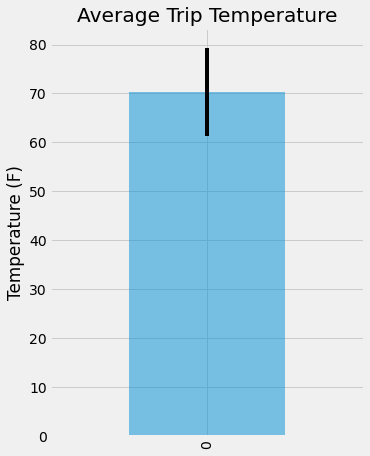

In [12]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yearly_temps_df.plot.bar(y="avg_temp", yerr=(yearly_temps_df['max_temp'] - yearly_temps_df['min_temp']), title="Average Trip Temperature", figsize=(5,7), alpha=0.5, legend=None)
plt.ylabel("Temperature (F)")

### Daily Rainfall Average

In [13]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total_prcp_by_stat =(session.query(Measurement.station,Station.name,func.sum(Measurement.prcp),
                                  Station.latitude,Station.longitude,Station.elevation)
                    .filter(Measurement.date >= start_date)
                    .filter(Measurement.date <= end_date)
                    .filter(Measurement.station == Station.station)
                    .group_by(Measurement.station)
                    .order_by(func.sum(Measurement.prcp)
                    .desc()).all())

print(f"Total rainfall by weather station for dates between {start_date} and {end_date}.")
total_prcp_by_stat_df = pd.DataFrame(total_prcp_by_stat, columns=['station', 'name', 'total_prcp', 'latitude', 'longitude', 'elevation'])

total_prcp_by_stat_df

Total rainfall by weather station for dates between 2016-03-18 and 2016-03-21.


,station,name,total_prcp,latitude,longitude,elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",0.29,21.33310,-157.80250,152.4
1,USC00519281,"WAIHEE 837.5, HI US",0.24,21.45167,-157.84889,32.9
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.16,21.52130,-157.83740,7.0
3,USC00513117,"KANEOHE 838.1, HI US",0.11,21.42340,-157.80150,14.6
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.00,21.33556,-157.71139,19.5
5,USC00519397,"WAIKIKI 717.2, HI US",0.00,21.27160,-157.81680,3.0


In [14]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [15]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2016-03-18'
end_date = '2016-03-21'


# Strip off the year and save a list of strings in the format %m-%d
trip_dates = ['03-18','03-19','03-20','03-21']

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []
def daily_normals(date):
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

for i in trip_dates:
    normals.append(daily_normals(i)[0])
normals

[(57.0, 67.7843137254902, 76.0),
 (60.0, 69.1, 75.0),
 (62.0, 70.11764705882354, 80.0),
 (60.0, 71.07692307692308, 77.0)]

In [16]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df = pd.DataFrame(normals, columns=['min_temp','avg_temp','max_temp'], index=trip_dates)
daily_normals_df.index.name='dates'

daily_normals_df

,min_temp,avg_temp,max_temp
dates,,,
03-18,57.0,67.784314,76.0
03-19,60.0,69.100000,75.0
03-20,62.0,70.117647,80.0
03-21,60.0,71.076923,77.0


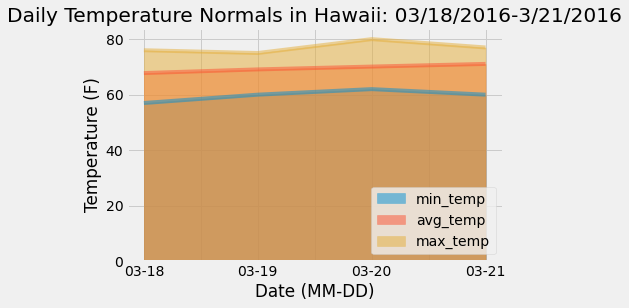

In [17]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot.area(stacked=False)
plt.title('Daily Temperature Normals in Hawaii: 03/18/2016-3/21/2016')
plt.xlabel("Date (MM-DD)")
plt.ylabel("Temperature (F)")
plt.legend(loc='lower right')

## Close Session

In [18]:
session.close()